# Read dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

column_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
                "hours-per-week", "native-country", "income"]

data = pd.read_csv('adult.data', names=column_names, sep='\s*,\s*')



/var/folders/mf/zbj6sw8d0z94s145kywy941c0000gn/T/ipykernel_11271/3544139266.py:24: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv('adult.data', names=column_names, sep='\s*,\s*')


# Data Visualizations

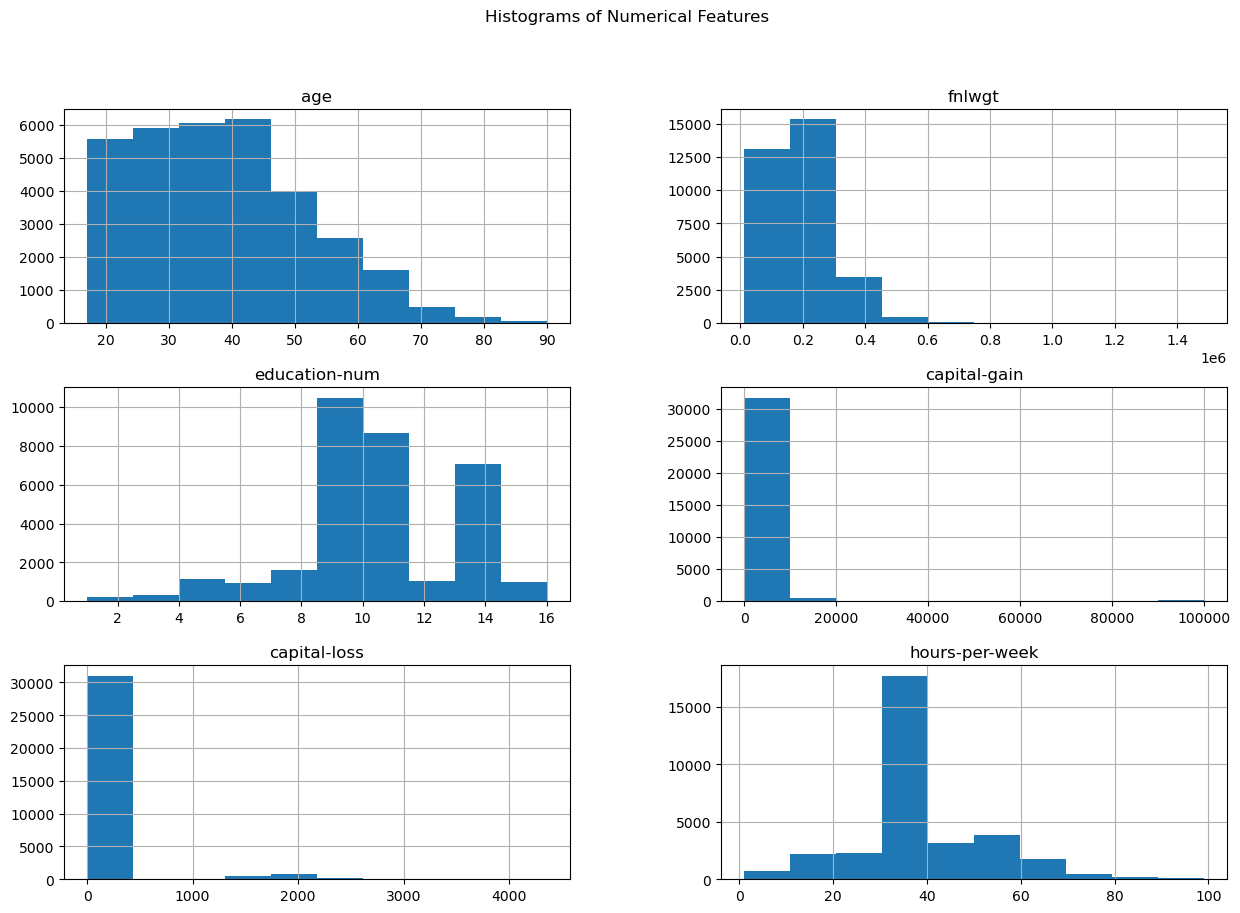

In [2]:
#Histograms for Numerical Features

num_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
data[num_features].hist(figsize=(15,10))
plt.suptitle("Histograms of Numerical Features")
plt.show()

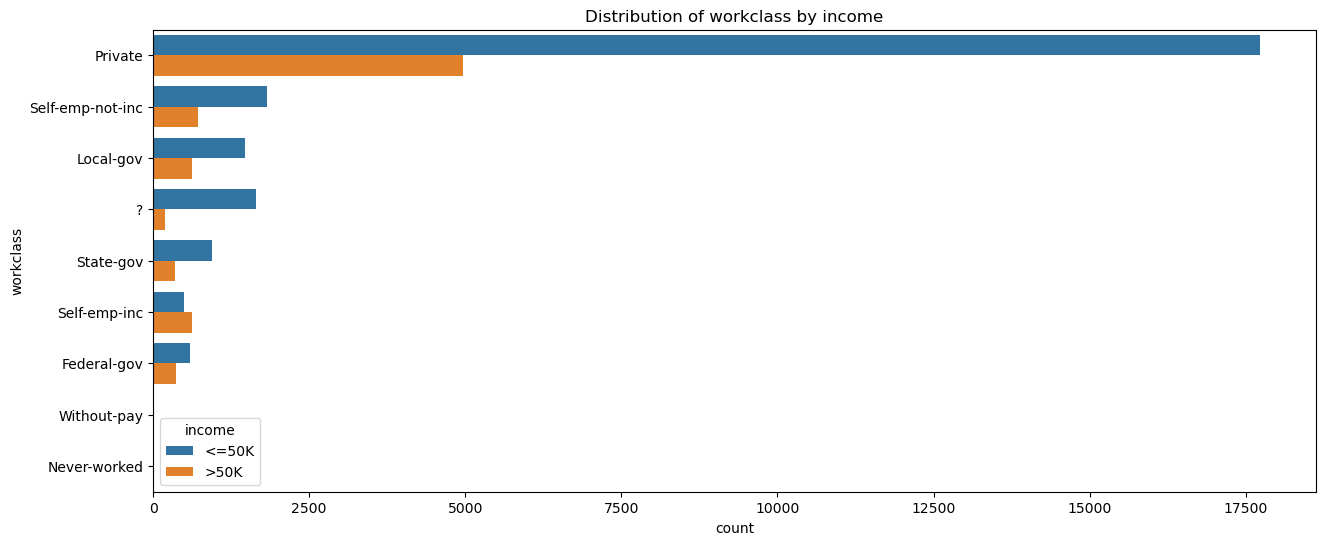

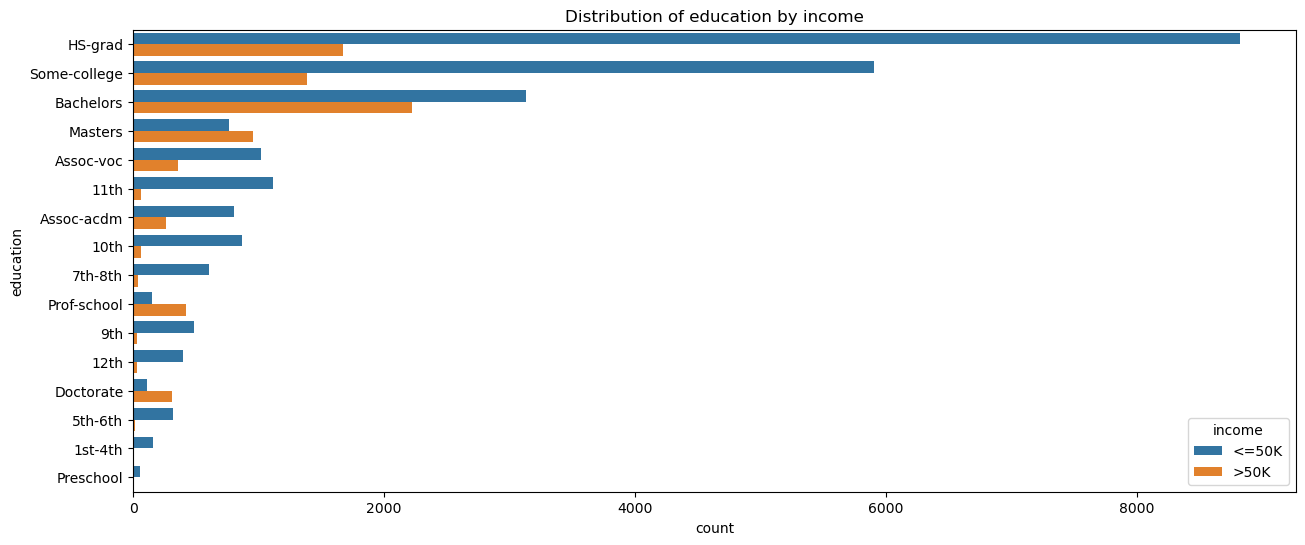

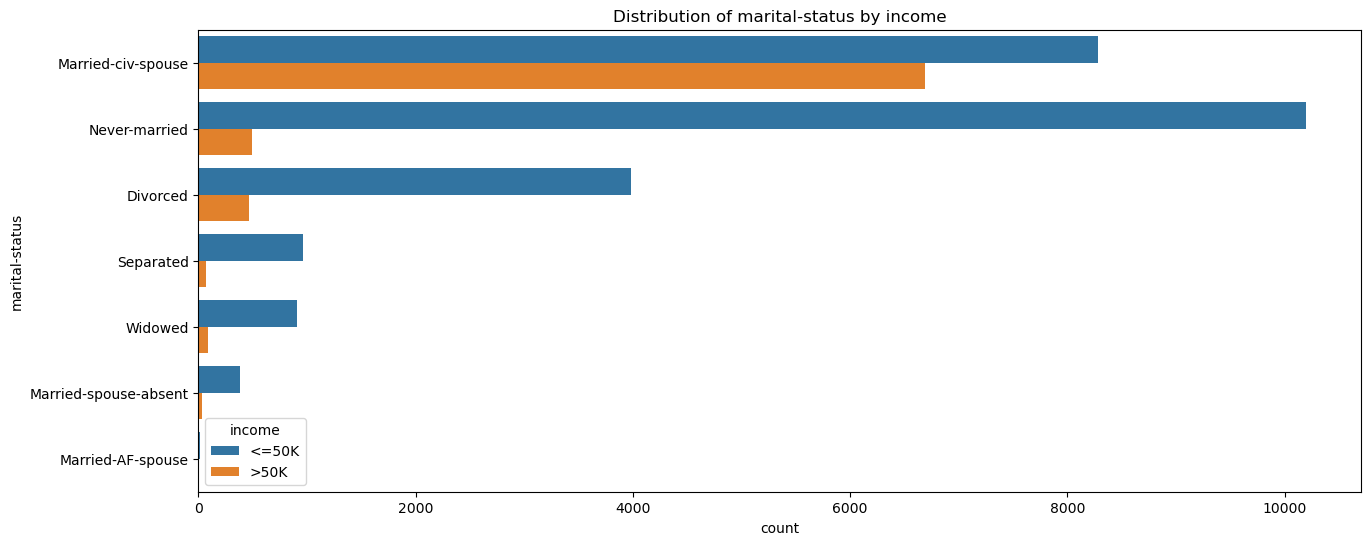

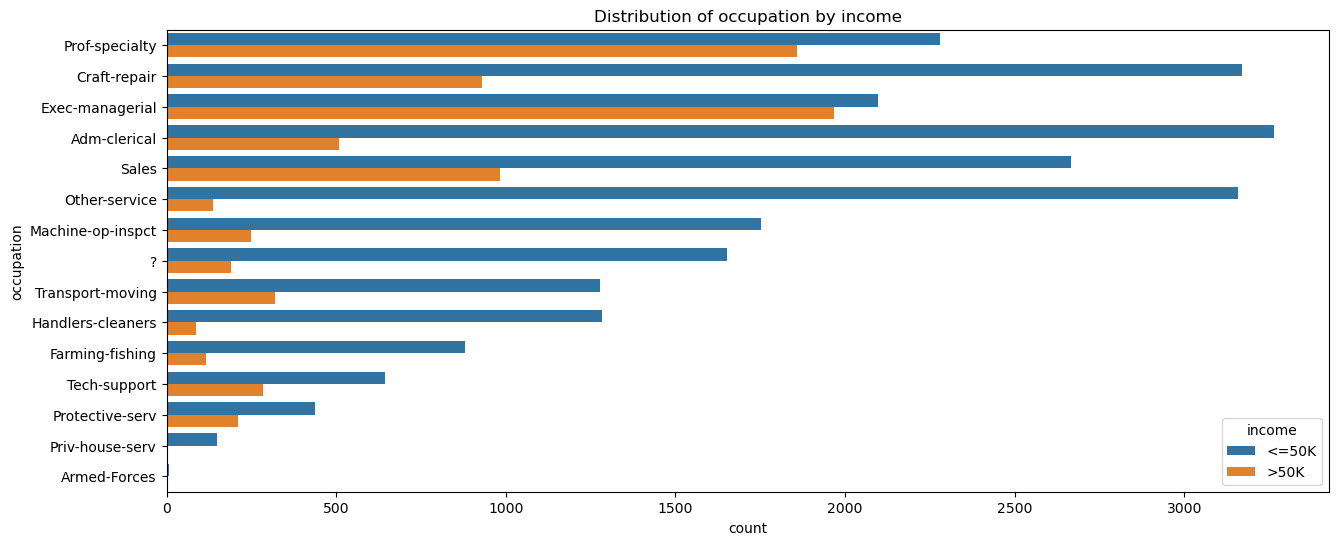

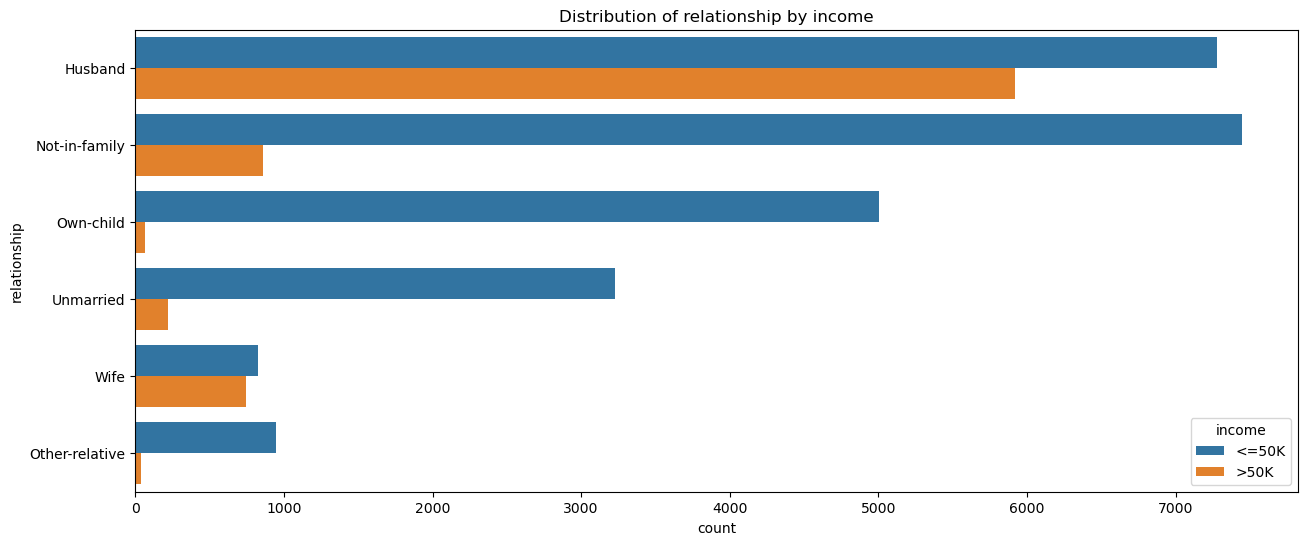

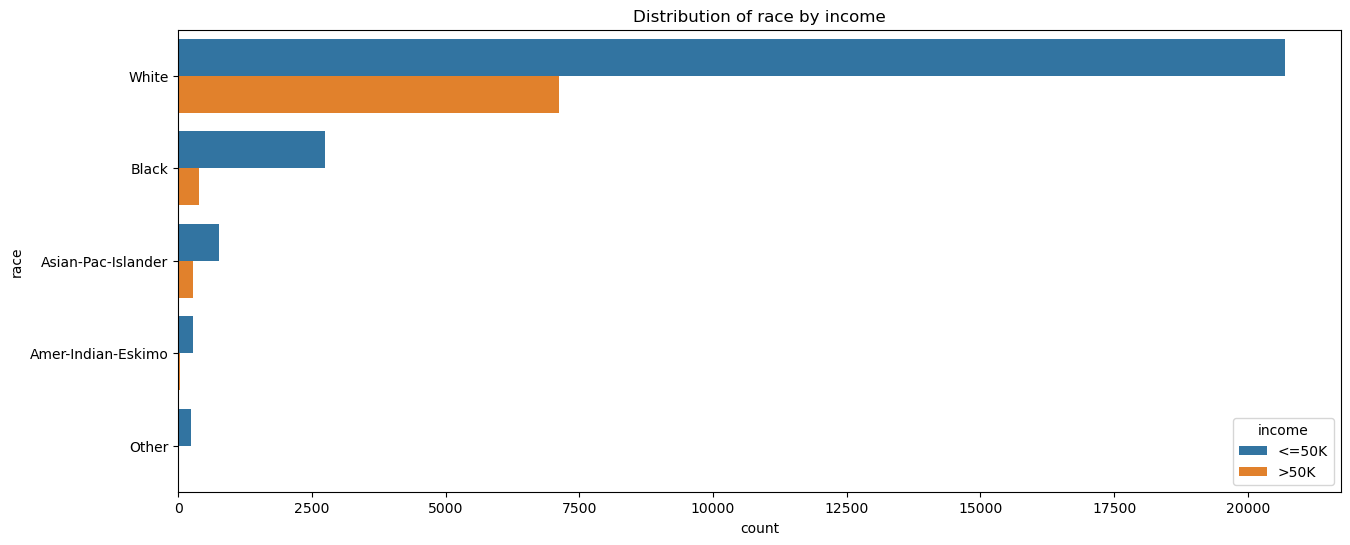

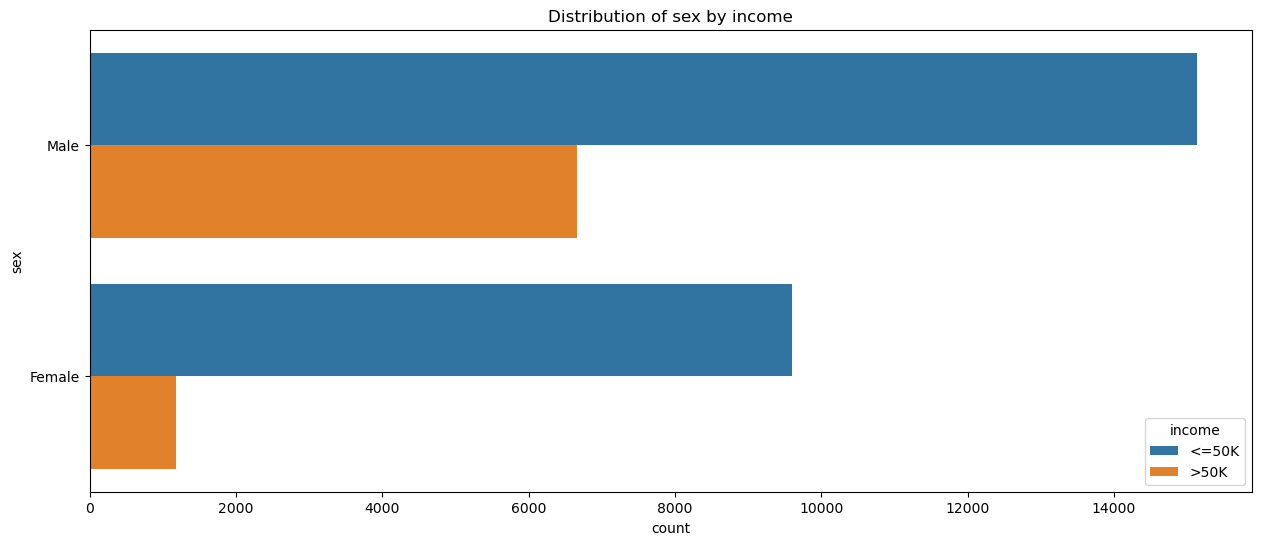

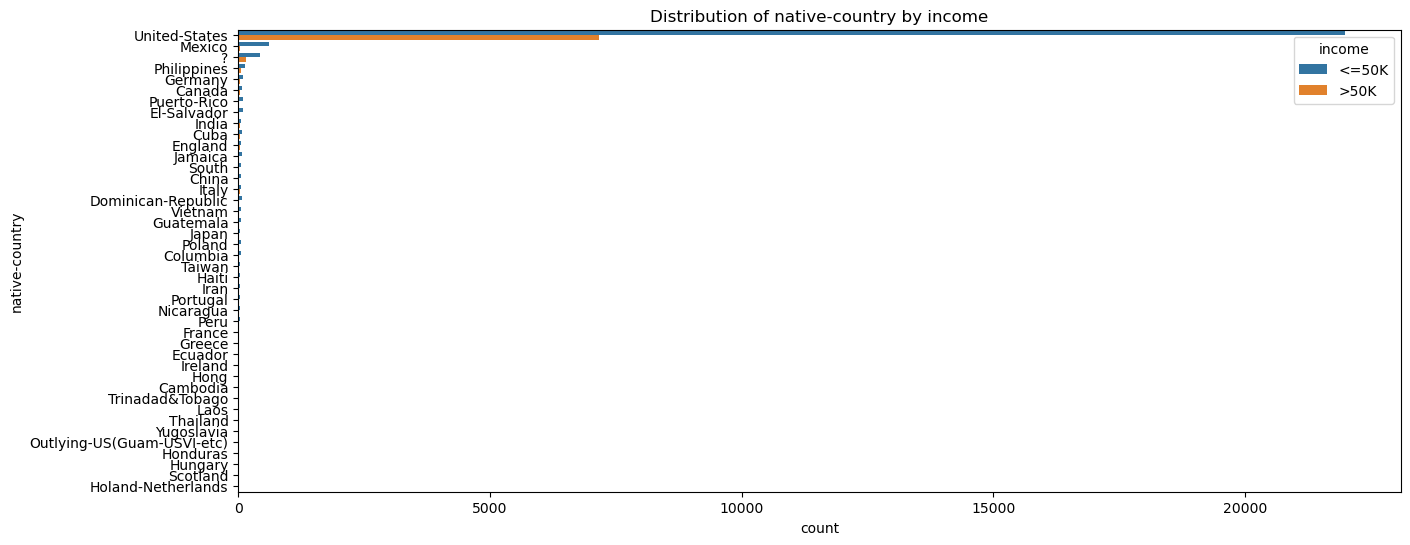

In [3]:
#Bar Plots for Categorical Features with income

cat_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
for feature in cat_features:
    plt.figure(figsize=(15,6))
    sns.countplot(y=feature, hue="income", data=data, order = data[feature].value_counts().index)
    plt.title(f"Distribution of {feature} by income")
    plt.show()


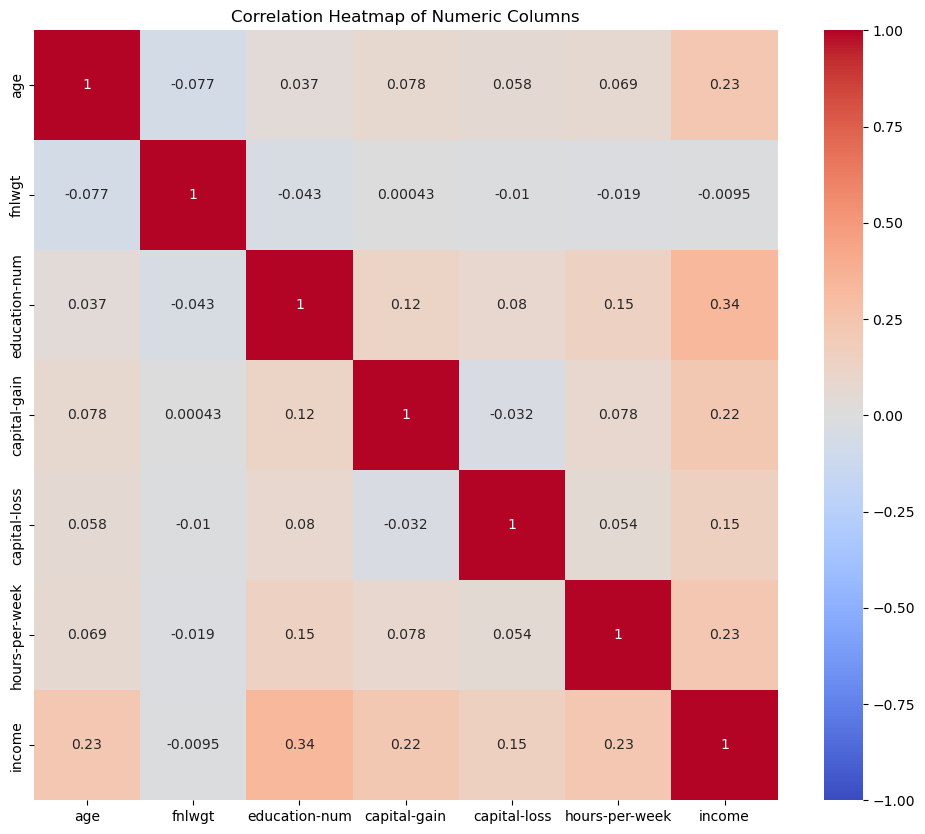

In [4]:
####heatmap before clean
data['income'] = data['income'].map({'>50K': 1, '<=50K': 0})

# Filtering numeric columns from a dataset
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Compute the correlation matrix for numerical columns
corr = numeric_data.corr()

# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

# Data Cleaning

In [5]:
######Data cleaning

# read data
db_adult = pd.read_csv("adult.data", sep=",", header=None)

# name columns
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
                "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
                "hours_per_week", "native_country", "income"]
db_adult.columns = column_names

##drop education and fnlwgt( unnecessary data)

db_adult.drop(columns=["education", "fnlwgt"], inplace=True)

# Copying the original data for subsequent viewing
db_adult_original = db_adult.copy()

# Output the statistics of the data before replacement
print("Before replacement:")
for column in db_adult_original.select_dtypes(include=['object']).columns:
    print(f"Column: {column}")
    print(db_adult_original[column].value_counts())
    print("-------------\n")

# Replace missing values in classification features with 'unknown'
categorical_columns = db_adult.select_dtypes(include=['object']).columns
for column in categorical_columns:
    db_adult[column] = db_adult[column].astype(str).replace(" ?", "unknown")

# Replace missing values in numeric features with 0
numerical_columns = db_adult.select_dtypes(exclude=['object']).columns
for column in numerical_columns:
    db_adult[column].fillna(0, inplace=True)

# Renumber the rows of the data frame
db_adult.index = range(1, len(db_adult) + 1)

# print the data
print("After replacement:")
for column in db_adult.select_dtypes(include=['object']).columns:
    print(f"Column: {column}")
    print(db_adult[column].value_counts())
    print("-------------\n")



Before replacement:
Column: workclass
workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: count, dtype: int64
-------------

Column: marital_status
marital_status
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: count, dtype: int64
-------------

Column: occupation
occupation
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective

# Outlier Detection

            age  education-num  capital-gain  capital-loss  hours-per-week
0      0.030671       1.134739      0.148453      -0.21666       -0.035429
1      0.837109       1.134739     -0.145920      -0.21666       -2.222153
2     -0.042642      -0.420060     -0.145920      -0.21666       -0.035429
3      1.057047      -1.197459     -0.145920      -0.21666       -0.035429
4     -0.775768       1.134739     -0.145920      -0.21666       -0.035429
...         ...            ...           ...           ...             ...
32556 -0.849080       0.746039     -0.145920      -0.21666       -0.197409
32557  0.103983      -0.420060     -0.145920      -0.21666       -0.035429
32558  1.423610      -0.420060     -0.145920      -0.21666       -0.035429
32559 -1.215643      -0.420060     -0.145920      -0.21666       -1.655225
32560  0.983734      -0.420060      1.888424      -0.21666       -0.035429

[32561 rows x 5 columns]
Number of outliers detected by z-score: 2410


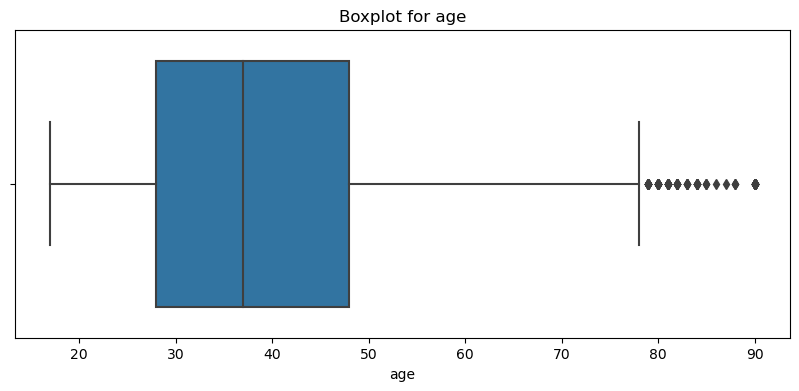

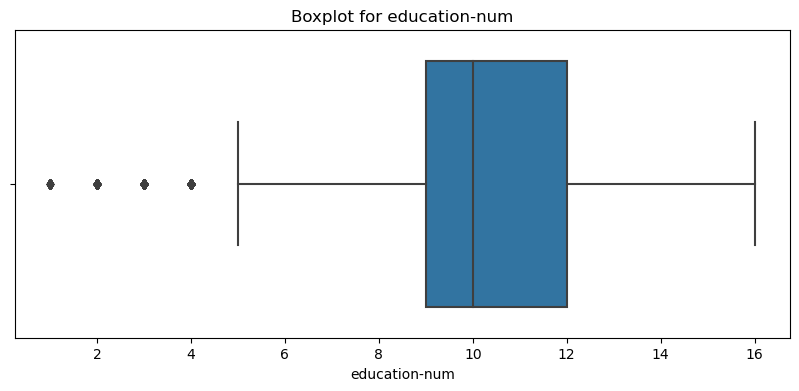

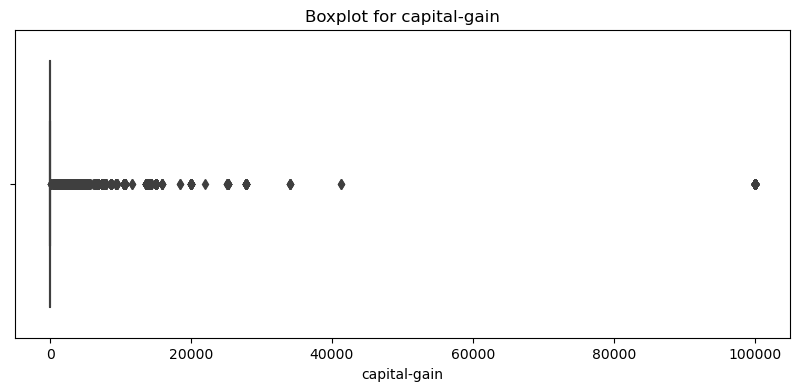

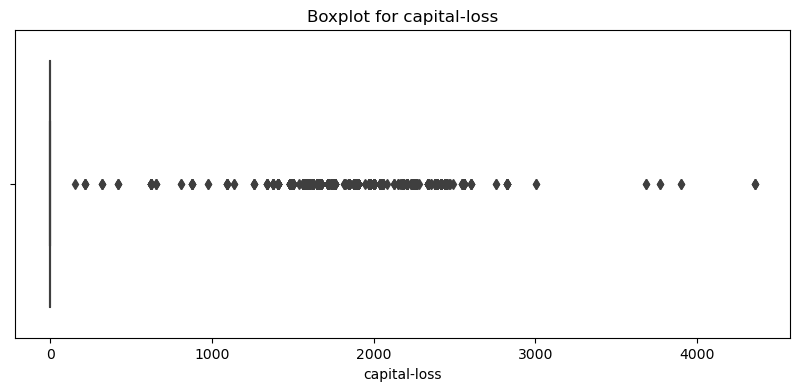

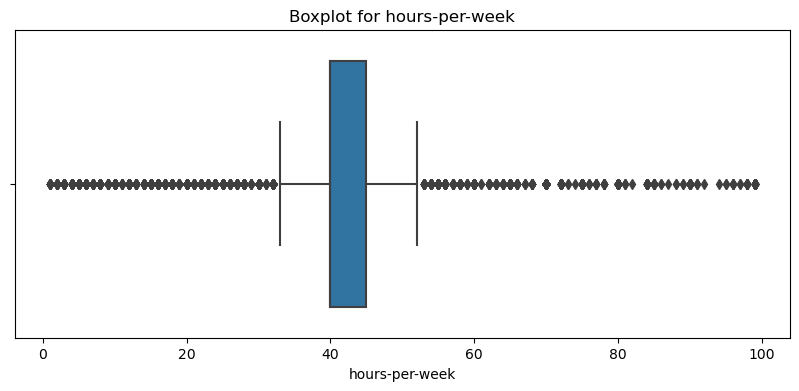

In [6]:
##Before outlier detection

# import data and check z score
numeric_cols = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
z_scores = zscore(data[numeric_cols])
print(z_scores)
abs_z_scores = np.abs(z_scores)

# Find rows where any column has an absolute z-score > 3
outliers_zscore = (abs_z_scores > 3).any(axis=1)

# Count the number of outliers
num_outliers = outliers_zscore.sum()

print(f"Number of outliers detected by z-score: {num_outliers}")

##box plot
for col in numeric_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot for {col}")
    plt.show()




            age  education-num  capital-gain  capital-loss  hours-per-week
0      0.030671       1.134739      0.148453      -0.21666       -0.035429
1      0.837109       1.134739     -0.145920      -0.21666       -2.222153
2     -0.042642      -0.420060     -0.145920      -0.21666       -0.035429
3      1.057047      -1.197459     -0.145920      -0.21666       -0.035429
4     -0.775768       1.134739     -0.145920      -0.21666       -0.035429
...         ...            ...           ...           ...             ...
32556 -0.849080       0.746039     -0.145920      -0.21666       -0.197409
32557  0.103983      -0.420060     -0.145920      -0.21666       -0.035429
32558  1.423610      -0.420060     -0.145920      -0.21666       -0.035429
32559 -1.215643      -0.420060     -0.145920      -0.21666       -1.655225
32560  0.983734      -0.420060      1.888424      -0.21666       -0.035429

[32561 rows x 5 columns]
The percentage of people working 90-100 hours per week is: 0.43%
Number of

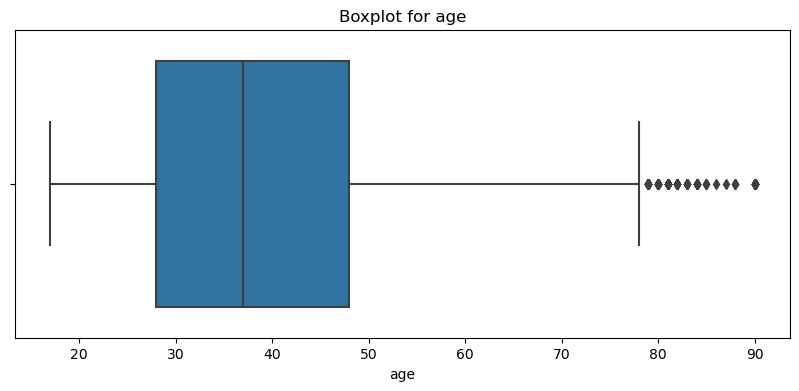

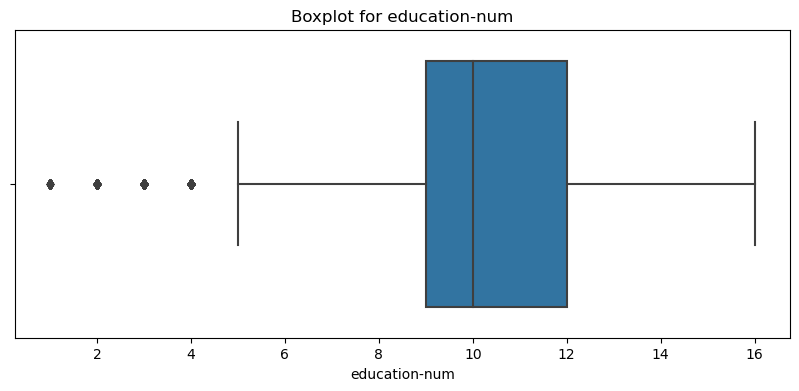

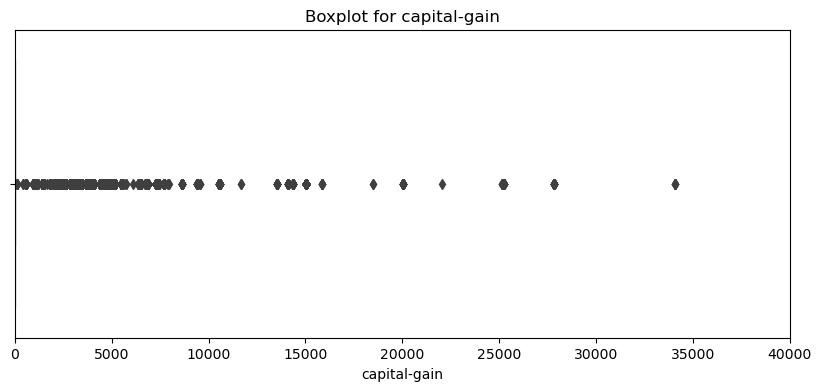

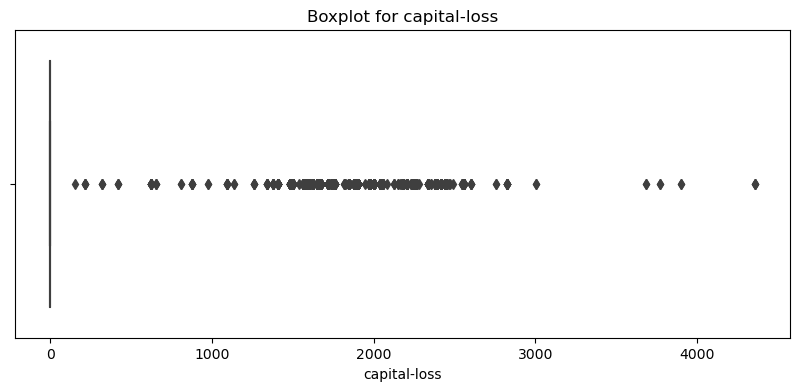

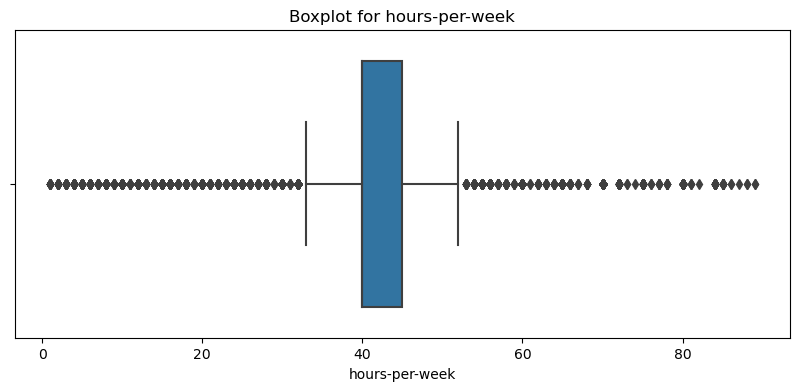

In [7]:
#After outlier detection

# import data and check z scores.
numeric_cols = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
z_scores = zscore(data[numeric_cols])
print(z_scores)
abs_z_scores = np.abs(z_scores)

# checking work hours per week
filtered_data = data[(data["hours-per-week"] >= 90) & (data["hours-per-week"] <= 100)]

percentage = (len(filtered_data) / len(data)) * 100

print(f"The percentage of people working 90-100 hours per week is: {percentage:.2f}%")

## delete 90-100 hours/per week

data = data[(data["hours-per-week"] < 90) | (data["hours-per-week"] > 100)]

# Find rows where any column has an absolute z-score > 3
outliers_zscore = (abs_z_scores > 3).any(axis=1)

# Count the number of outliers
num_outliers = outliers_zscore.sum()

print(f"Number of outliers detected by z-score: {num_outliers}")

##box plot

for col in numeric_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot for {col}")
    if col == "capital-gain":
        plt.xlim(0, 40000)  # Setting the x-axis limit to 40000 only for "capital-gain"
    plt.show()



# Encoding

In [8]:
#encoding
### Replace all values in the native-country column that are not 'United-States' with 'Others'
data['native-country'] = data['native-country'].apply(lambda x: 'United-States' if x == 'United-States' else 'Others')
# One-Hot encoding
cat_features = [
    "workclass", "marital-status", "occupation", "relationship", "race",
    "sex", "native-country", "education"  # Add all other categorical features except 'income'
]
data_encoded = pd.get_dummies(data, columns=cat_features)
print(data_encoded.head())


   age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   39   77516             13          2174             0              40   
1   50   83311             13             0             0              13   
2   38  215646              9             0             0              40   
3   53  234721              7             0             0              40   
4   28  338409             13             0             0              40   

   income  workclass_?  workclass_Federal-gov  workclass_Local-gov  ...  \
0       0        False                  False                False  ...   
1       0        False                  False                False  ...   
2       0        False                  False                False  ...   
3       0        False                  False                False  ...   
4       0        False                  False                False  ...   

   education_9th  education_Assoc-acdm  education_Assoc-voc  \
0          False       

# Model update

## Random forest

In [16]:
# model of random forest after using one hot encoding
# Select all features for training except the target variable 'income'
X_encodedrf = data_encoded.drop('income', axis=1)#unless income
y_encodedrf = data_encoded['income']
# Split the data into training and testing sets
X_train_encodedrf, X_test_encodedrf, y_train_encodedrf, y_test_encodedrf = train_test_split(X_encodedrf, y_encodedrf, test_size=0.2, random_state=42)

# create a random forest model
rf_encoded = RandomForestClassifier(n_estimators=100, random_state=42)

# train the model
rf_encoded.fit(X_train_encodedrf, y_train_encodedrf)

# predict
y_pred_encodedrf = rf_encoded.predict(X_test_encodedrf)

# Evaluating model performance
accuracy_encoded = accuracy_score(y_test_encodedrf, y_pred_encodedrf)
print(f"Accuracy with One-Hot Encoding: {accuracy_encoded * 100:.2f}%")
###############HP
# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100,150,250,500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20]
}
                                                                                            
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_encoded, param_grid=param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_encodedrf, y_train_encodedrf)

# Get the best parameters from grid search
print("Best parameters from Grid Search: ", grid_search.best_params_)



Accuracy with One-Hot Encoding: 85.94%
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


/Users/young/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters from Grid Search:  {'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 150}


In [17]:
####After CV, we use grid search bulid a new model

# Best parameters from Grid Search
params_grid_search = {'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 150}

# Create a RandomForestClassifier with the best parameters
rfbest_model = RandomForestClassifier(**params_grid_search, random_state=42)

# we will fit the model
rfbest_model.fit(X_train_encodedrf, y_train_encodedrf)

# 
y_pred_encodedrfnew = rfbest_model.predict(X_test_encodedrf)
new_accuracy_encodedrf = accuracy_score(y_test_encodedrf, y_pred_encodedrfnew)
print(f"new Accuracy with One-Hot Encoding: {new_accuracy_encodedrf * 100:.2f}%")

new Accuracy with One-Hot Encoding: 86.92%


Sensitivity: 0.63
Specificity: 0.94
Precision: 0.77
Confusion Matrix Accuracy: 0.87
Confusion Matrix:
[[4685  289]
 [ 559  952]]


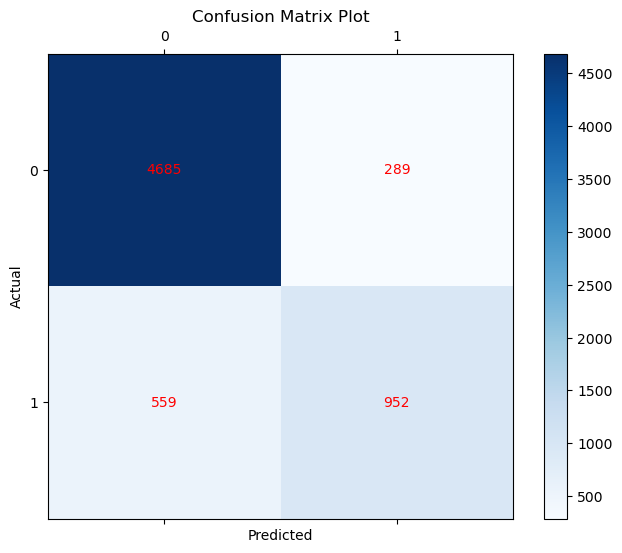

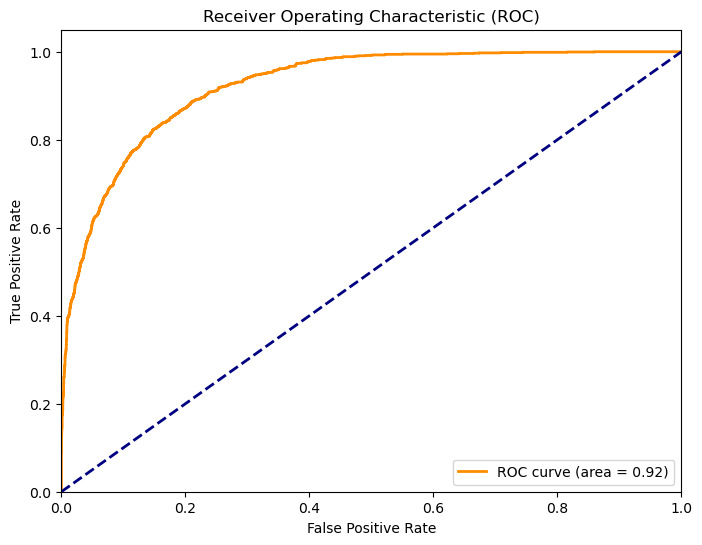

In [21]:
####We use new model to do the confusion matrix and auc roc
##S and S
# Calculate confusion matrix to get sensitivity and specificity
cmrf = confusion_matrix(y_test_encodedrf, y_pred_encodedrfnew)
TP = cmrf[1, 1]  # True Positives
TN = cmrf[0, 0]  # True Negatives
FP = cmrf[0, 1]  # False Positives
FN = cmrf[1, 0]  # False Negatives
# Calculate sensitivity (Recall or True Positive Rate)
sensitivity = TP / float(TP + FN)
print(f"Sensitivity: {sensitivity:.2f}")

# Calculate specificity (True Negative Rate)
specificity = TN / float(TN + FP)
print(f"Specificity: {specificity:.2f}")
# Calculate precision
precision = TP / float(TP + FP)
print(f"Precision: {precision:.2f}")
# Calculate accuracy from the confusion matrix
accuracy_cmrf = (TP + TN) / float(TP + TN + FP + FN)
print(f"Confusion Matrix Accuracy: {accuracy_cmrf:.2f}")
# Calculate the confusion matrix
print("Confusion Matrix:")
print(cmrf)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.matshow(cmrf, cmap=plt.cm.Blues, fignum=1)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

for i in range(cmrf.shape[0]):
    for j in range(cmrf.shape[1]):
        plt.text(j, i, cmrf[i, j], ha='center', va='center', color='red')

plt.show()
#########
###ROC and AUC
# 用随机森林模型的predict_proba方法获取测试集每个样本的类别预测概率
# 我们需要正类的概率，通常是predict_proba输出的第二列
y_scores_encodedrf = rfbest_model.predict_proba(X_test_encodedrf)[:, 1]
# 计算真正阳性率（TPR）和假正阳性率（FPR）
fpr_encodedrf, tpr_encodedrf, _ = roc_curve(y_test_encodedrf, y_scores_encodedrf)

# 计算AUC
roc_auc_encodedrf = auc(fpr_encodedrf, tpr_encodedrf)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_encodedrf, tpr_encodedrf, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_encodedrf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## SVM

### SVM old model and grid search

In [25]:
###SVM
# Prepare the features and target variable
X_encodedsvm = data_encoded.drop('income', axis=1)
Y_encodedsvm = data_encoded['income']

# Split the data into training and testing sets
X_train_encodedsvm, X_test_encodedsvm, y_train_encodedsvm, y_test_encodedsvm = train_test_split(X_encodedsvm, Y_encodedsvm, test_size=0.2, random_state=42)

# Initialize the SVM classifier
svm_encoded = SVC(random_state=42, probability=True)

# Train the SVM classifier
svm_encoded.fit(X_train_encodedsvm, y_train_encodedsvm)

# Predict using the trained SVM model
y_pred_encoded = svm_encoded.predict(X_test_encodedsvm)

# Calculate the accuracy
accuracy_encoded = accuracy_score(y_test_encodedsvm, y_pred_encoded)
print(f"Accuracy with One-Hot Encoding using SVM: {accuracy_encoded * 100:.2f}%")

######
######HP

# Define the parameter grid for Grid Search
param_grid_svm = {
    'C': [0.1, 1, 10],  # Regularization parameter
}

# Initialize the SVM classifier
svm_classifier = SVC(random_state=42)

# Create a GridSearchCV object for SVM
grid_search_svm = GridSearchCV(estimator=svm_encoded, param_grid=param_grid_svm, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_svm.fit(X_train_encodedsvm, y_train_encodedsvm)

# Get the best parameters from grid search
print("Best parameters from Grid Search for SVM: ", grid_search_svm.best_params_)


Accuracy with One-Hot Encoding using SVM: 80.19%
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters from Grid Search for SVM:  {'C': 10}


### New SVM model

In [29]:
#########SVM modelnew
# the best parameters are c = 10
params_grid_search_svm = {'C': 10}

# use best params to creat a new model 
svm_best_model = SVC(**params_grid_search_svm, probability=True,random_state=42)

# 我们将拟合模型 we will fit the model
svm_best_model.fit(X_train_encodedsvm, y_train_encodedsvm)

# predict the model
y_pred_encoded_svmnew = svm_best_model.predict(X_test_encodedsvm)
new_accuracy_encoded_svm = accuracy_score(y_test_encodedsvm, y_pred_encoded_svmnew)
print(f"new Accuracy with One-Hot Encoding for SVM: {new_accuracy_encoded_svm * 100:.2f}%")


new Accuracy with One-Hot Encoding for SVM: 80.48%


### Confusion matrix and AUC ROC 

Sensitivity: 0.20
Specificity: 0.99
Precision: 0.84
Confusion Matrix Accuracy: 0.80
Confusion Matrix:
[[4918   56]
 [1210  301]]


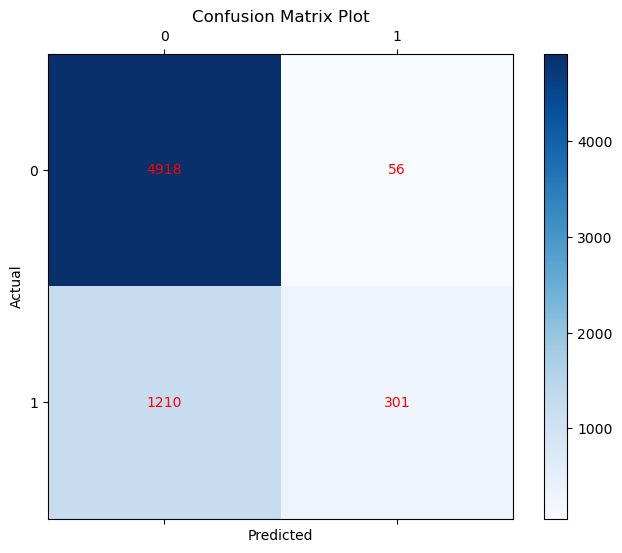

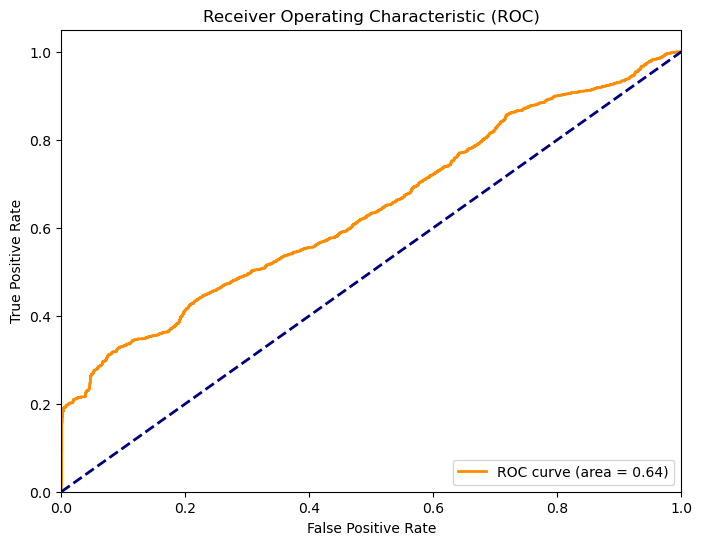

In [30]:
########We use new model to do the confusion matrix and auc roc
##S and S
# Calculate confusion matrix to get sensitivity and specificity
cmsvm = confusion_matrix(y_test_encodedsvm, y_pred_encoded_svmnew)
TP = cmsvm[1, 1]  # True Positives
TN = cmsvm[0, 0]  # True Negatives
FP = cmsvm[0, 1]  # False Positives
FN = cmsvm[1, 0]  # False Negatives

# Calculate sensitivity (Recall or True Positive Rate)
sensitivity = TP / float(TP + FN)
print(f"Sensitivity: {sensitivity:.2f}")

# Calculate specificity (True Negative Rate)
specificity = TN / float(TN + FP)
print(f"Specificity: {specificity:.2f}")
# Calculate precision
precision = TP / float(TP + FP)
print(f"Precision: {precision:.2f}")
# Calculate accuracy from the confusion matrix
accuracy_cmsvm = (TP + TN) / float(TP + TN + FP + FN)
print(f"Confusion Matrix Accuracy: {accuracy_cmsvm:.2f}")
#Calculate the confusion matrix
print("Confusion Matrix:")
print(cmsvm)
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.matshow(cmsvm, cmap=plt.cm.Blues, fignum=1)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

for i in range(cmsvm.shape[0]):
    for j in range(cmsvm.shape[1]):
        plt.text(j, i, cmsvm[i, j], ha='center', va='center', color='red')

plt.show()
#########ROC and AUC 
y_scores_encodedsvm = svm_best_model.predict_proba(X_test_encodedsvm)[:, 1]
# Compute ROC curve and ROC AUC
fpr_encodedsvm, tpr_encodedsvm, _ = roc_curve(y_test_encodedsvm, y_scores_encodedsvm)
roc_auc_encodedsvm = auc(fpr_encodedsvm, tpr_encodedsvm)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_encodedsvm, tpr_encodedsvm, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_encodedsvm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## Logstic regression

### Logstic regression old model and grid search

In [31]:
###Logstic regression
# Prepare the features and target variable
X_encodedlr = data_encoded.drop('income', axis=1)
Y_encodedlr = data_encoded['income']

# Split the data into training and testing sets
X_train_encodedlr, X_test_encodedlr, y_train_encodedlr, y_test_encodedlr = train_test_split(X_encodedlr, Y_encodedlr, test_size=0.2, random_state=42)

# Initialize the Logistic Regression classifier
logistic_regression = LogisticRegression(random_state=42, max_iter=10000)

# Train the Logistic Regression classifier
logistic_regression.fit(X_train_encodedlr, y_train_encodedlr)

# Predict using the trained Logistic Regression model
y_pred_encodedlr = logistic_regression.predict(X_test_encodedlr)

# Calculate the accuracy
accuracy_encodedlr = accuracy_score(y_test_encodedlr, y_pred_encodedlr)
print(f"Accuracy with One-Hot Encoding using Logistic Regression: {accuracy_encodedlr * 100:.2f}%")

#####hyper parameter for grid search

# Define the parameter grid for Grid Search
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Specifies the norm used in the penalization
    'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
}


# Create a GridSearchCV object for Logistic Regression
grid_search_lr = GridSearchCV(estimator=logistic_regression, param_grid=param_grid_lr, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_lr.fit(X_train_encodedlr, y_train_encodedlr)

# Get the best parameters from grid search
print("Best parameters from Grid Search for Logistic Regression: ", grid_search_lr.best_params_)


Accuracy with One-Hot Encoding using Logistic Regression: 80.40%
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters from Grid Search for Logistic Regression:  {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


### New logstic regression model 

In [32]:
###
# 最佳参数来自网格搜索
best_params_lr = {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

# Initialize the Logistic Regression classifier with the best parameters
logistic_regression_best = LogisticRegression(**best_params_lr, random_state=42, max_iter=10000)

# Train the Logistic Regression classifier with the best parameters
logistic_regression_best.fit(X_train_encodedlr, y_train_encodedlr)

# Predict using the trained Logistic Regression model with the best parameters
y_pred_encodedlr_bestnew = logistic_regression_best.predict(X_test_encodedlr)

# Calculate the accuracy for the model with the best parameters
accuracy_encodedlr_best = accuracy_score(y_test_encodedlr, y_pred_encodedlr_bestnew)
print(f"Accuracy with One-Hot Encoding using Logistic Regression with Grid Search Best Params: {accuracy_encodedlr_best * 100:.2f}%")


Accuracy with One-Hot Encoding using Logistic Regression with Grid Search Best Params: 85.46%


### Confusion matrix and AUC ROC for new lr model

Sensitivity: 0.60
Specificity: 0.93
Precision: 0.73
Confusion Matrix Accuracy: 0.85
Confusion Matrix:
[[4634  340]
 [ 603  908]]


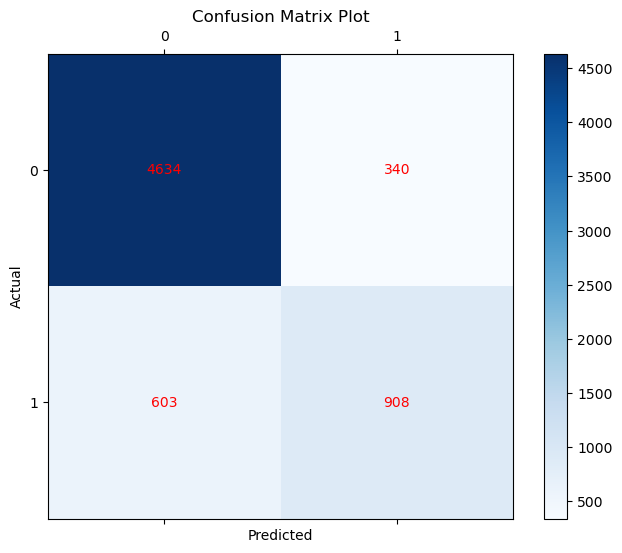

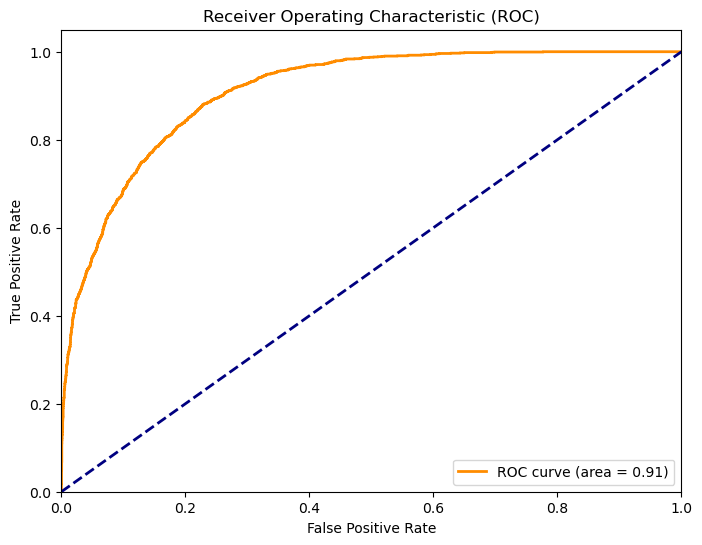

In [34]:
##S and S
# Calculate confusion matrix to get sensitivity and specificity
cmlr = confusion_matrix(y_test_encodedlr, y_pred_encodedlr_bestnew)
TP = cmlr[1, 1]  # True Positives
TN = cmlr[0, 0]  # True Negatives
FP = cmlr[0, 1]  # False Positives
FN = cmlr[1, 0]  # False Negatives

# Calculate sensitivity (Recall or True Positive Rate)
sensitivity = TP / float(TP + FN)
print(f"Sensitivity: {sensitivity:.2f}")

# Calculate specificity (True Negative Rate)
specificity = TN / float(TN + FP)
print(f"Specificity: {specificity:.2f}")
# Calculate precision
precision = TP / float(TP + FP)
print(f"Precision: {precision:.2f}")
# Calculate accuracy from the confusion matrix
accuracy_cmlr = (TP + TN) / float(TP + TN + FP + FN)
print(f"Confusion Matrix Accuracy: {accuracy_cmlr:.2f}")
#Calculate the confusion matrix
print("Confusion Matrix:")
print(cmlr)
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.matshow(cmlr, cmap=plt.cm.Blues, fignum=1)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

for i in range(cmlr.shape[0]):
    for j in range(cmlr.shape[1]):
        plt.text(j, i, cmlr[i, j], ha='center', va='center', color='red')

plt.show()

###AUC and ROC
# Predict probabilities for ROC AUC
y_scores_encodedlr = logistic_regression_best.predict_proba(X_test_encodedlr)[:, 1]

# Compute ROC curve and ROC AUC
fpr_encodedlr, tpr_encodedlr, _ = roc_curve(y_test_encodedlr, y_scores_encodedlr)
roc_auc_encodedlr = auc(fpr_encodedlr, tpr_encodedlr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_encodedlr, tpr_encodedlr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_encodedlr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## gradient boosting classifier

### Old GBC model and grid search

In [35]:
###gradient boosting classifier
# Prepare the features and target variable
X_encodedgb = data_encoded.drop('income', axis=1)
Y_encodedgb = data_encoded['income']

# Split the data into training and testing sets
X_train_encodedgb, X_test_encodedgb, y_train_encodedgb, y_test_encodedgb = train_test_split(X_encodedgb, Y_encodedgb, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier(random_state=42)

# Train the Gradient Boosting Classifier
gradient_boosting.fit(X_train_encodedgb, y_train_encodedgb)

# Predict using the trained Gradient Boosting model
y_pred_encoded = gradient_boosting.predict(X_test_encodedgb)

# Calculate the accuracy
accuracy_encodedgb = accuracy_score(y_test_encodedgb, y_pred_encoded)
print(f"Accuracy with Gradient Boosting Classifier: {accuracy_encodedgb * 100:.2f}%")
################## HP
# Define the parameter grid for Grid Search
param_grid_gb = {
    'n_estimators': [50, 100, 150, 200,300],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6,7]
}
# Create a GridSearchCV object
grid_search_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid_gb, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_gb.fit(X_train_encodedgb, y_train_encodedgb)
# Get the best parameters from grid search
print("Best parameters from Grid Search for Gradient Boosting: ", grid_search_gb.best_params_)
#######



Accuracy with Gradient Boosting Classifier: 86.68%
Fitting 10 folds for each of 125 candidates, totalling 1250 fits
Best parameters from Grid Search for Gradient Boosting:  {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300}


### New GBC model

In [36]:
###New model for GBC
#we use the best parameters 
best_params_gb = {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 6}
# use the best parameters to create a new gb model
gradient_boosting_best = GradientBoostingClassifier(**best_params_gb, random_state=42)

# fit the model 
gradient_boosting_best.fit(X_train_encodedgb, y_train_encodedgb)

# predicting
y_pred_encoded_bestgbnew = gradient_boosting_best.predict(X_test_encodedgb)

# print the new model accuracy
accuracy_encodedgb_best = accuracy_score(y_test_encodedgb, y_pred_encoded_bestgbnew)
print(f"Accuracy with Gradient Boosting Classifier using Grid Search Best Params: {accuracy_encodedgb_best * 100:.2f}%")

Accuracy with Gradient Boosting Classifier using Grid Search Best Params: 87.68%


### Confusion matrix and AUC ROC for new lr model¶

Sensitivity: 0.67
Specificity: 0.94
Precision: 0.77
Confusion Matrix Accuracy: 0.88
Confusion Matrix:
[[4678  296]
 [ 503 1008]]


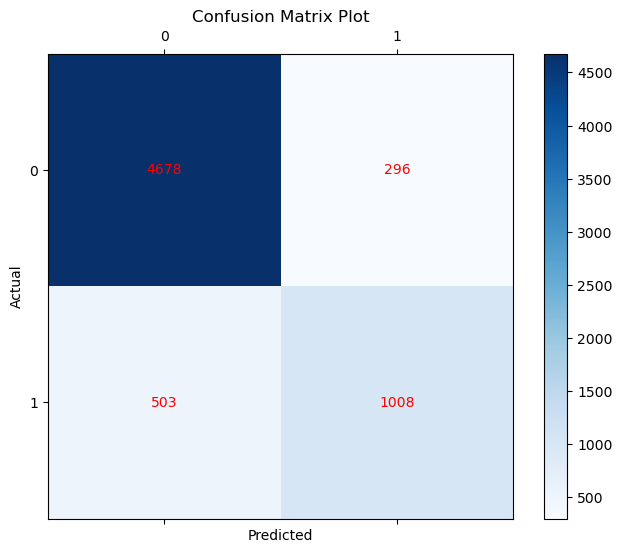

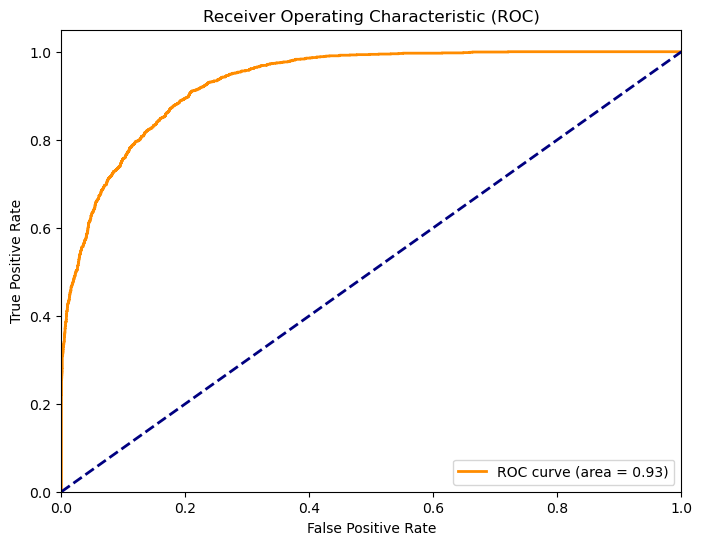

In [37]:
#S and S
# Calculate confusion matrix to get sensitivity and specificity
cmgb = confusion_matrix(y_test_encodedgb, y_pred_encoded_bestgbnew)
TP = cmgb[1, 1]  # True Positives
TN = cmgb[0, 0]  # True Negatives
FP = cmgb[0, 1]  # False Positives
FN = cmgb[1, 0]  # False Negatives


# Calculate sensitivity (Recall or True Positive Rate)
sensitivity = TP / float(TP + FN)
print(f"Sensitivity: {sensitivity:.2f}")

# Calculate specificity (True Negative Rate)
specificity = TN / float(TN + FP)
print(f"Specificity: {specificity:.2f}")
# Calculate precision
precision = TP / float(TP + FP)
print(f"Precision: {precision:.2f}")
# Calculate accuracy from the confusion matrix
accuracy_cmgb = (TP + TN) / float(TP + TN + FP + FN)
print(f"Confusion Matrix Accuracy: {accuracy_cmgb:.2f}")
#Calculate the confusion matrix
print("Confusion Matrix:")
print(cmgb)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.matshow(cmgb, cmap=plt.cm.Blues, fignum=1)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

for i in range(cmgb.shape[0]):
    for j in range(cmgb.shape[1]):
        plt.text(j, i, cmgb[i, j], ha='center', va='center', color='red')

plt.show()

####
##ROC and AUC

# Predict probabilities for ROC AUC
y_scores_encodedgb = gradient_boosting_best.predict_proba(X_test_encodedgb)[:, 1]
fpr_encodedgb, tpr_encodedgb, _ = roc_curve(y_test_encodedgb, y_scores_encodedgb)
roc_auc_encodedgb = auc(fpr_encodedgb, tpr_encodedgb)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_encodedgb, tpr_encodedgb, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_encodedgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()